In [3]:
import innvestigate
import innvestigate.utils
import keras.applications.vgg16 as vgg16

eutils = imp.load_source("utils", "../utils.py")

# Get some example test set images.
images, label_to_class_name = eutils.get_imagenet_data(net["image_shape"][0])

if not len(images):
    raise Exception("Please download the example images using: "
                    "'innvestigate/examples/images/wget_imagenet_2011_samples.sh'")

# Choose a sample image and add batch axis
image = images[0][0][None, :, :, :]
# Preprocess it for VGG16
image_pp = imgnetutils.preprocess(image, net)
# Displaying the image
plot.imshow(image[0]/255)
plot.show()

# Get model
model, preprocess = vgg16.VGG16(), vgg16.preprocess_input
# Strip softmax layer
model = innvestigate.utils.model_wo_softmax(model)

# Create analyzer
analyzer = innvestigate.create_analyzer("deep_taylor", model)

# Add batch axis and preprocess
x = preprocess(image[None])
# Apply analyzer w.r.t. maximum activated output-neuron
a = analyzer.analyze(x)

# Aggregate along color channels and normalize to [-1, 1]
a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
a /= np.max(np.abs(a))
# Plot
plt.imshow(a[0], cmap="seismic", clim=(-1, 1))

NameError: name 'imp' is not defined

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras

from PIL import Image

from utils.explain import get_classifier, create_train_val, get_datasets, ClassifierTrainer

Using TensorFlow backend.


In [3]:
keras.__version__

'2.2.4'

In [4]:
IMG_HEIGHT = 128
model, preprocessing_layer = get_classifier((IMG_HEIGHT,IMG_HEIGHT,3))














Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
def lr_schedule(epoch, lr):
    """
    Returns a custom learning rate that decreases as epochs progress.
    """
    if epoch <= 25:
        return lr
    if epoch <= 50:
        return lr/10
    if epoch <= 75:
        return lr/100
    else:
        return lr/1000

optimiser = keras.optimizers.Adam(lr=1e-3)

In [6]:
train_dataset, val_dataset = get_datasets('classifier_train_data',
                                          'classifier_val_data',
                                          preprocessing_layer,
                                          img_height=IMG_HEIGHT,
                                          img_width=IMG_HEIGHT,
                                          batch_size=32)

Found 2742 images belonging to 19 classes.
Found 688 images belonging to 19 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


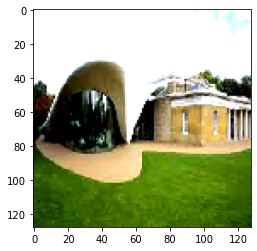

In [7]:
X, y = next(iter(val_dataset))
plt.imshow(X[1]*0.5+0.5)
plt.show()

In [8]:
trainer = ClassifierTrainer(train_dataset, val_dataset, model, optimiser, lr_schedule)

In [12]:
# trainer.train(epochs = 10)

Epoch 1/10
86/86 [==============================] - ETA: 0s - loss: 1.1599 - accuracy: 0.7020
Epoch 00001: saving model to C:\Users\Starlight\Desktop\creative-machine-learning\classifier_1x_checkpoints\cp.ckpt
86/86 [==============================] - 14s 166ms/step - loss: 1.1599 - accuracy: 0.7020 - val_loss: 5.2790 - val_accuracy: 0.2994
Epoch 2/10
86/86 [==============================] - ETA: 0s - loss: 0.9751 - accuracy: 0.7454
Epoch 00002: saving model to C:\Users\Starlight\Desktop\creative-machine-learning\classifier_1x_checkpoints\cp.ckpt
86/86 [==============================] - 14s 163ms/step - loss: 0.9751 - accuracy: 0.7454 - val_loss: 2.0378 - val_accuracy: 0.6090
Epoch 3/10
86/86 [==============================] - ETA: 0s - loss: 0.7717 - accuracy: 0.7987
Epoch 00003: saving model to C:\Users\Starlight\Desktop\creative-machine-learning\classifier_1x_checkpoints\cp.ckpt
86/86 [==============================] - 14s 165ms/step - loss: 0.7717 - accuracy: 0.7987 - val_loss: 1.69

In [9]:
trainer.infer('classifier_infer_data', preprocessing_layer, IMG_HEIGHT, IMG_HEIGHT)

Model Loaded
Inference Completed


NameError: name 'iutils' is not defined

In [16]:
preprocessing_layer(np.array(Image.open('classifier_data/google_pavilion_2000/0385529262.jpg'))).shape

(600, 900, 3)

### Investigate

In [120]:
import innvestigate
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis

from keras.preprocessing.image import img_to_array, load_img
from utils.explain import plot_image_grid

In [15]:
modified_model = iutils.keras.graph.model_wo_softmax(model)
analyzer = innvestigate.create_analyzer("deep_taylor", modified_model)

In [26]:
img = np.expand_dims(preprocessing_layer(img_to_array(load_img('classifier_infer_data/2006.jpg', target_size=(IMG_HEIGHT, IMG_HEIGHT)))), axis=0)

In [27]:
# Apply analyzer w.r.t. maximum activated output-neuron
a = analyzer.analyze(img)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


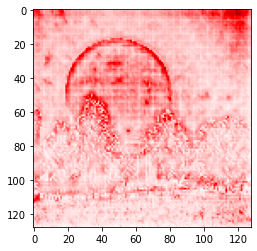

In [28]:
# Aggregate along color channels and normalize to [-1, 1]
a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
a /= np.max(np.abs(a))
# Plot
plt.imshow(a[0], cmap="seismic", clim=(-1, 1))

In [126]:
graymap = lambda x: ivis.graymap(np.abs(x), input_is_positive_only=True)
noise_scale = (2.7*2) * 0.1 # Approx input range * 0.1
# Configure analysis methods and properties
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN               TITLE

    # Function
    ("gradient",              {"postprocess": "abs"},   graymap,        "Gradient"),
    ("smoothgrad",            {"noise_scale": noise_scale,
                               "postprocess": "square"},graymap,        "SmoothGrad"),

#     # Signal
    ("deconvnet",             {},                       ivis.graymap,        "Deconvnet"),
    ("guided_backprop",       {},                       ivis.graymap,        "Guided Backprop",),

#     # Interaction
#     ("pattern.attribution",   {"pattern_type": "relu"}, mnistutils.heatmap,        "PatternAttribution"),
#     ("deep_taylor.bounded",   {"low": input_range[0],
#                                "high": input_range[1]}, mnistutils.heatmap,        "DeepTaylor"),
#     ("input_t_gradient",      {},                       mnistutils.heatmap,        "Input * Gradient"),
#     ("integrated_gradients",  {"reference_inputs": ri}, mnistutils.heatmap,        "Integrated Gradients"),
#     #("deep_lift.wrapper",     {"reference_inputs": ri}, mnistutils.heatmap,        "DeepLIFT Wrapper - Rescale"),
#     #("deep_lift.wrapper",     {"reference_inputs": ri, "nonlinear_mode": "reveal_cancel"},
#     #                                                    mnistutils.heatmap,        "DeepLIFT Wrapper - RevealCancel"),
#     ("lrp.z",                 {},                       mnistutils.heatmap,        "LRP-Z"),
#     ("lrp.epsilon",           {"epsilon": 1},           mnistutils.heatmap,        "LRP-Epsilon"),
]

In [127]:
methods

[('gradient',
  {'postprocess': 'abs'},
  <function __main__.<lambda>(x)>,
  'Gradient'),
 ('smoothgrad',
  {'noise_scale': 0.54, 'postprocess': 'square'},
  <function __main__.<lambda>(x)>,
  'SmoothGrad'),
 ('deconvnet',
  {},
  <function innvestigate.utils.visualizations.graymap(X, **kwargs)>,
  'Deconvnet'),
 ('guided_backprop',
  {},
  <function innvestigate.utils.visualizations.graymap(X, **kwargs)>,
  'Guided Backprop')]

In [128]:
# Create analyzers.
analyzers = []
for method in methods:
    analyzer = innvestigate.create_analyzer(
        method[0],                     # analysis method identifier
        modified_model,              # model without softmax output
        neuron_selection_mode="index", # We want to select the output neuron to analyze.
        **method[1])                   # optional analysis parameters

    # Some analyzers require training.
    analyzer.fit(train_dataset, batch_size=32, verbose=1)
    analyzers.append(analyzer)

In [129]:
label_to_class = {int(v):k for k,v in val_dataset.class_indices.items()}
label_to_class

{0: 'google_pavilion_2000',
 1: 'google_pavilion_2001',
 2: 'google_pavilion_2002',
 3: 'google_pavilion_2003',
 4: 'google_pavilion_2005',
 5: 'google_pavilion_2006',
 6: 'google_pavilion_2007',
 7: 'google_pavilion_2008',
 8: 'google_pavilion_2009',
 9: 'google_pavilion_2010',
 10: 'google_pavilion_2011',
 11: 'google_pavilion_2012',
 12: 'google_pavilion_2013',
 13: 'google_pavilion_2014',
 14: 'google_pavilion_2015',
 15: 'google_pavilion_2016',
 16: 'google_pavilion_2017',
 17: 'google_pavilion_2018',
 18: 'google_pavilion_2019'}

In [130]:
x, y = next(val_dataset)
x = np.expand_dims(x[0], axis=0)
y = np.expand_dims(y[0], axis=0).astype(np.int32)
print(x.shape, y.shape)

(1, 128, 128, 3) (1,)


In [131]:
analyzers

In [132]:
analysis = np.zeros([5, len(analyzers), IMG_HEIGHT, IMG_HEIGHT, 3])
text = []

for ii, output_neuron in enumerate(range(num_classes)):
    # Predict final activations, probabilites, and label.
    presm = modified_model.predict_on_batch(x)[0]
    prob = model.predict_on_batch(x)[0]
    y_hat = prob.argmax()

    # Save prediction info:
    text.append(("%s" % label_to_class[y.item()],    # ground truth label
                 "%.2f" % presm[output_neuron],    # pre-softmax logits
                 "%.2f" % prob[output_neuron],     # probabilistic softmax output  
                 "%s" % label_to_class[output_neuron]
                ))

    for aidx, analyzer in enumerate(analyzers):
        # Analyze.
        a = analyzer.analyze(x, neuron_selection=output_neuron)

        # Apply common postprocessing, e.g., re-ordering the channels for plotting.
        a = iutils.postprocess_images(a.copy())
        # Apply analysis postprocessing, e.g., creating a heatmap.
        a = methods[aidx][2](a)
        # Store the analysis.
        analysis[ii, aidx] = a[0]

--------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

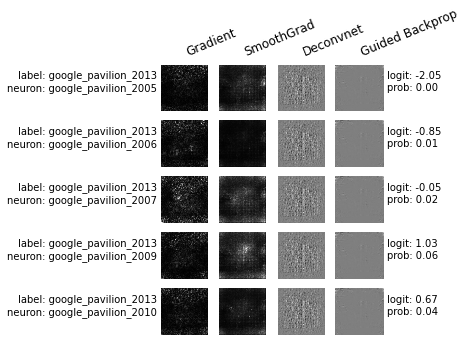

In [133]:
print("-"*80)
# print("Image nr. {}: ".format(image_nr))
# Prepare the grid as rectengular list
grid = [[analysis[i, j] for j in range(analysis.shape[1])]
        for i in range(analysis.shape[0])]
# Prepare the labels
label, presm, prob, pred = zip(*text)
row_labels_left = [('label: {}'.format(label[i]), 'neuron: {}'.format(pred[i])) for i in range(len(label))]
row_labels_right = [('logit: {}'.format(presm[i]), 'prob: {}'.format(prob[i])) for i in range(len(label))]
col_labels = [''.join(method[3]) for method in methods]

# Plot the analysis.
plot_image_grid(grid, row_labels_left, row_labels_right, col_labels)